In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Run only once
!pip install numpy==1.23.5 --force-reinstall
!pip install catboost --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 69.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you hav

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9

0:	learn: 4.7887304	test: 4.6693316	best: 4.6693316 (0)	total: 21.7ms	remaining: 21.6s
100:	learn: 1.7836850	test: 1.8317058	best: 1.8317058 (100)	total: 2.09s	remaining: 18.6s
200:	learn: 1.6464888	test: 1.8119115	best: 1.8119040 (199)	total: 3.38s	remaining: 13.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.807681598
bestIteration = 242

Shrink model to first 243 iterations.

📊 Validation Results:
MAE: 25,582,652.26
RMSE: 79,778,110.81
Custom ±10M Accuracy: 88.54%

📊 Test Results:
MAE: 24,176,324.70
RMSE: 65,909,749.03
Custom ±10M Accuracy: 89.30%


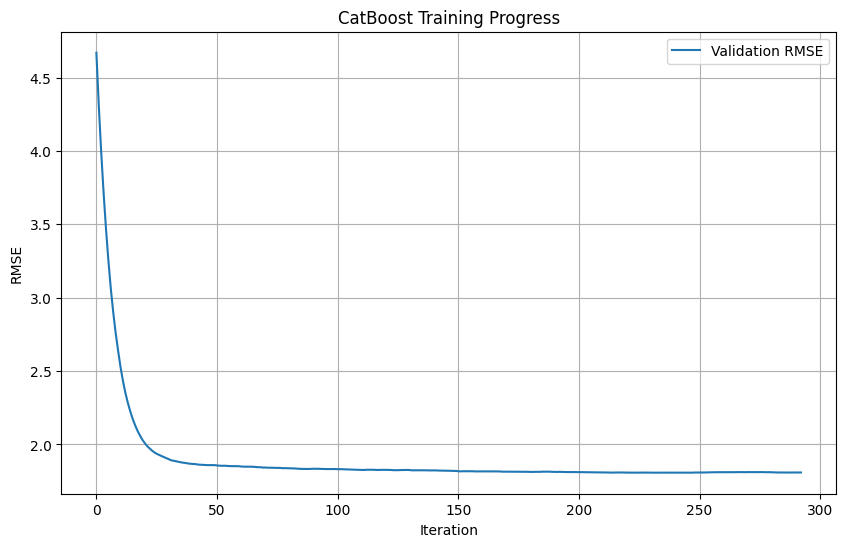

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# === 1. Loading enriched dataset ===
df = pd.read_csv('/content/drive/My Drive/cleaned_movies_with_sentiment.csv')

# === 2. Converting release_date to datetime format ===
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# === 3. Performing feature engineering ===
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['cast_count'] = df['top_cast'].fillna('').str.split(', ').apply(len)
df['genre_count'] = df['genres'].fillna('').str.split(', ').apply(len)
df['keyword_count'] = df['keywords'].fillna('').str.split(', ').apply(len)

# Extracting top 50 directors and assigning others as 'other'
top_directors = df['director'].value_counts().nlargest(50).index
df['director_clean'] = df['director'].apply(lambda x: x if x in top_directors else 'other')

# Extracting top 50 production companies and assigning others as 'other'
df['main_prod_company'] = df['production_companies'].str.split(', ').str[0]
top_companies = df['main_prod_company'].value_counts().nlargest(50).index
df['main_prod_company'] = df['main_prod_company'].apply(lambda x: x if x in top_companies else 'other')

# Applying log transformation to revenue (target)
df['log_revenue'] = np.log1p(df['revenue'])

# === 4. Defining sentiment and emotion columns and giving more weight ===
sentiment_emotion_cols = [
    'very_negative', 'neutral', 'very_positive',
    'anger', 'disgust', 'joy', 'sadness'
]
for col in sentiment_emotion_cols:
    df[col] = df[col] * 3  # Apply weighting

# === 5. Defining features and target columns ===
drop_cols = ['movie_id', 'imdb_id', 'title', 'revenue', 'release_date',
             'genres', 'top_cast', 'keywords', 'production_companies',
             'director', 'genres_list', 'top_cast_list', 'keywords_list']

features = [col for col in df.columns if col not in drop_cols + ['log_revenue']]
X = df[features]
y = df['log_revenue']

# === 6. Splitting dataset ===
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

# === 7. Listing categorical feature names ===
cat_features = ['language', 'status', 'main_prod_company', 'director_clean']

# === 8. Initializing and training CatBoost model ===
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=cat_features,
    use_best_model=True
)

# === 9. Evaluation function ===
def evaluate(model, X, y_true, label):
    y_pred = model.predict(X)
    y_pred_rev = np.expm1(y_pred)
    y_true_rev = np.expm1(y_true)

    mae = mean_absolute_error(y_true_rev, y_pred_rev)
    rmse = np.sqrt(mean_squared_error(y_true_rev, y_pred_rev))
    within_range = np.abs(y_pred_rev - y_true_rev) <= 10000000
    custom_acc = np.mean(within_range)

    print(f"\n📊 {label} Results:")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"Custom ±10M Accuracy: {custom_acc * 100:.2f}%")

# === 10. Evaluate ===
evaluate(model, X_val, y_val, "Validation")
evaluate(model, X_test, y_test, "Test")

# === 11. Training progress plot ===
def plot_training_progress(model):
    evals = model.get_evals_result()
    rmse_vals = evals['validation']['RMSE']

    plt.figure(figsize=(10, 6))
    plt.plot(rmse_vals, label='Validation RMSE')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('CatBoost Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_progress(model)
